# CS-6570 Assignment 3 - Variable Selection

*Weber State University*

Rob Christiansen


For this assignment we're going to build and attempt to optimize regression models using some of the techniques we're learned so far in class.

First, let's import our favorite libraries:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt

There are also some libraries and functions we'll need for creating and testing our models:

In [2]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.metrics import mean_squared_error

The dataset we'll use for this is the "Hitters" dataset ("Hitters.csv"), which is a dataset of Major League Baseball player statistics from 1986-1987. More info about the dataset can be found [here](https://www.kaggle.com/datasets/floser/hitters).

In [3]:
df_hitters = pd.read_csv('Datasets/Hitters.csv')
df_hitters.head()

,Unnamed: 0,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,...,CRuns,CRBI,CWalks,League,Division,PutOuts,Assists,Errors,Salary,NewLeague
0,-Andy Allanson,293,66,1,30,29,14,1,293,66,...,30,29,14,A,E,446,33,20,NaN,A
1,-Alan Ashby,315,81,7,24,38,39,14,3449,835,...,321,414,375,N,W,632,43,10,475.0,N
2,-Alvin Davis,479,130,18,66,72,76,3,1624,457,...,224,266,263,A,W,880,82,14,480.0,A
3,-Andre Dawson,496,141,20,65,78,37,11,5628,1575,...,828,838,354,N,E,200,11,3,500.0,N
4,-Andres Galarraga,321,87,10,39,42,30,2,396,101,...,48,46,33,N,E,805,40,4,91.5,N


Let's rename that first column.

In [4]:
df_hitters.rename(columns={"Unnamed: 0": "Player"}, inplace=True) #Name the first column "Player"

Note that the Salary variable is missing for some of the players. The isnull() function can be used to identify the missing observations. It returns a vector of the same length as the input vector, with a TRUE value for any elements that are missing, and a FALSE value for non-missing elements. The sum() function can then be used to count all of the missing elements:

In [5]:
print("Number of null values:", df_hitters["Salary"].isnull().sum())

Number of null values: 59


We see that Salary is missing for 59 players. That's not too many. Let's drop them. The dropna() function removes all of the rows that have missing values in any variable:

In [6]:
# Print the dimensions of the original Hitters data (322 rows x 20 columns)
print("Dimensions of original data:", df_hitters.shape)

# Drop any rows the contain missing values, along with the player names
df_hitters_clean = df_hitters.dropna()

# Print the dimensions of the modified Hitters data (263 rows x 20 columns)
print("Dimensions of modified data:", df_hitters_clean.shape)

# One last check: should return 0
print("Number of null values:", df_hitters_clean["Salary"].isnull().sum())

Dimensions of original data: (322, 21)
Dimensions of modified data: (263, 21)
Number of null values: 0


Alright, so we've now dropped all the rows with missing data.

Some of our predictors are categorical, so for this exercise we'll eliminate those. We'll also specify the variable, "Salary", that we're trying to predict.

In [7]:
#Create the response variable.
y = df_hitters_clean.Salary

# Drop the column with the independent variable (Salary), and the columns with categorical data
#The axis=1 parameter specifies we're dropping columns, and not rows.
#The .astype('float64') casts all remaining data as floats.
X = df_hitters_clean.drop(['Salary', 'League', 'Division', 'NewLeague', 'Player'], axis=1)
X

,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors
1,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10
2,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14
3,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3
4,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4
5,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,497,127,7,65,48,37,5,2703,806,32,379,311,138,325,9,3
318,492,136,5,76,50,94,12,5511,1511,39,897,451,875,313,381,20
319,475,126,3,61,43,52,6,1700,433,7,217,93,146,37,113,7
320,573,144,9,85,60,78,8,3198,857,97,470,420,332,1314,131,12


Now, for this assignment we're going to create a subset that will be our training data, and a subset that will be our test data. Let's do an 80/20 split:

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2,random_state = 42)

## Backward Subset Selection ##

If we build a linear model with all these inputs, we'll likely overfit the model. To avoid this, we'd like to build a model using only the most important variables. But, which subset of variables is most important?

In lecture 9, we learned three methods for selecting the best subset of variables for a linear model:

* Best subset selection
* Forward stepwise selection
* Backward stepwised selection

We went over algorithms for each of these, and implemented two (best subset and forward stepwise) as Python code. In this assignment, you'll implement backward stepwise selection.

The basic algorithm for backward stepwise selection is:

_Algorithm_

- Let $M_{p}$ denote the full model which contains all $p$ predictors.

- For $k=p,p-1,...,1$
    - Consider all $k$ models that contain all but one of the predictors in $M_{k}$, for a total of $k-1$ predictors.
    - Pick the best among these $k$ models, and call in $M_{k-1}$. Here can define _best_ as having the smallest $RSS$ or highest $R^{2}$
- Select the single best model among $M_{0},M_{1},...,M_{n}$ using $C_{p}$, $BIC$, adjusted $R^{2}$ or any other method.

For this assignment, use the largest $R^{2}$ to determine the best model at each step, and select the overall best model using the adjusted $R^{2}$.

We'll start out with a list of all the predictors:

In [9]:
backwards_features = list(X.columns)
p = len(backwards_features)

In [10]:
backwards_features

['AtBat',
 'Hits',
 'HmRun',
 'Runs',
 'RBI',
 'Walks',
 'Years',
 'CAtBat',
 'CHits',
 'CHmRun',
 'CRuns',
 'CRBI',
 'CWalks',
 'PutOuts',
 'Assists',
 'Errors']

We'll also create two empty lists that you should fill:
* *R2_list_backwards* - Fill this with the best $R^{2}$ value that you find at each step.
* *features_list_backwards* - Fill this with the best set of features that you find at each step.
* *R2_test_list_backwards* - Fill this with the performance of the model on the test data using the best set of features found at each step.

In [11]:
R2_list_backwards, features_list_backwards, R2_test_list_backwards = [], [], []

In [12]:
import numpy as np
exp_float = np.inf 
np.isinf(exp_float)

True

In [13]:
exp_float = 1.0
np.isinf(exp_float)

False

Alright, now it's time for you to write your own code! Write code that appropriately populates the two lists just created. However, do so using just the *X_train* and *y_train* datasets.

In [14]:
def fit_linear_reg(X,Y):
    #Fit linear regression model and return RSS and R squared values
    model_k = linear_model.LinearRegression()
    model_k.fit(X,Y)
    RSS = mean_squared_error(Y,model_k.predict(X)) * len(Y)
    R_squared = model_k.score(X,Y)
    return RSS, R_squared

In [15]:
RSS_list_backwards, R2_list_backwards, features_list_backwards, R2_test_list_backwards, features_list_count = [], [], [], [], []

In [16]:
import itertools

X = X_train
Y = y_train

remaining_features = list(X.columns.values)
features, worst_features, best_features = [], [], []
RSS_list, R_squared_list = [np.inf], [np.inf] #Due to 1 indexing of the loop...
features_list = dict()

for i in range(len(X.columns)+1,2,-1):        
    best_RSS, worst_RSS = np.inf, np.inf
    worst_feature = str
    
    for combo in itertools.combinations(remaining_features,1):
            features_to_evaluate = list(X.columns.values)           # Reset each inner loop
            # print(f"Pre features_to_evaluate: {features_to_evaluate}")
            for item in worst_features:                             # Remove previously found worst features
                if item in features_to_evaluate:
                    features_to_evaluate.remove(item)
            if combo[0] in features_to_evaluate:
                features_to_evaluate.remove(combo[0])                   # Remove the current feature being evaluated
            # print(f"Post features_to_evaluate after dropping {combo[0]}: {features_to_evaluate}")

            RSS = fit_linear_reg(X[features_to_evaluate],Y)         #Store temp result 

            if RSS[0] > worst_RSS or np.isinf(worst_RSS):           # Necessary to handle the initial state
                worst_RSS = RSS[0]
                worst_feature = combo[0]

            if RSS[0] < best_RSS:                                   # Not necessary to handle the empty case because best_RSS starts out as infinite so anything is smaller
                best_RSS = RSS[0]
                best_R_squared = RSS[1] 

                best_features = features_to_evaluate                                
                test_RSS = fit_linear_reg(X_test[features_to_evaluate],y_test)     # Run the test set R2 during processing
                best_R_squared_test = test_RSS[1]
                print(f"best_RSS: {best_RSS} with {best_features}")


    if worst_feature in best_features:
        best_features.remove(worst_feature)                   # Remove the current feature being evaluated

    print(f"Final best_RSS: {best_RSS} with {best_features}")
    print(f"Final worst_RSS: {worst_RSS} with {worst_feature}")                
    #Updating variables for next loop
    features.append(best_features)
    # remaining_features.remove(best_feature)
    worst_features.append(worst_feature)
    # remaining_features.remove(worst_feature)
    
    #Saving values for plotting
    RSS_list.append(best_RSS)
    R_squared_list.append(best_R_squared)
    features_list[i] = features.copy()

    # Set desired variables
    RSS_list.append(best_RSS)
    R2_list_backwards.append(best_R_squared)
    R2_test_list_backwards.append(best_R_squared_test)
    features_list[i] = best_features.copy()    # This is the important row to put into the dataframe
    features_list_count.append(len(features_to_evaluate))
    features_list_backwards.append(best_features)

best_RSS: 19272215.28083243 with ['Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']
best_RSS: 18719022.995231874 with ['AtBat', 'Hits', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']
best_RSS: 18708397.108700484 with ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists', 'Errors']
Final best_RSS: 18708397.108700484 with ['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'Assists', 'Errors']
Final worst_RSS: 19702355.85361821 with PutOuts
best_RSS: 20136647.752270237 with ['Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'Assists', 'Errors']
best_RSS: 19724595.74148884 with ['AtBat', 'Hits', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits

In [17]:
# import itertools

# # Forward Stepwise from Lecture

# X = X_train
# Y = y_train

# remaining_features = list(X.columns.values)
# temp_features = remaining_features                                      # Get the initial list built
# worst_features, features = [], []
# RSS_list, R_squared_list = [np.inf], [np.inf]
# features_list = dict()

# for i in range(len(X.columns)+1,1,-1):                                  # Changed this to go backwards and change the step value to -1
#     print(f"i: {i}")
#     best_RSS, worst_RSS, best_R_squared, best_R_squared_test = np.inf, np.inf, np.inf, np.inf  # Reset to float in outer loop
#     worst_feature = ''                                                  # Reset to empty string in outer loop
    
#     for combo in itertools.combinations(remaining_features,1):          # Interestingly, remaining_features itself seems to grow smaller with each iteration
#             temp_features = list(X.columns.values)                      # Reset to full list each inner loop
#             for item in worst_features:
#                 if item in temp_features:
#                     temp_features.remove(item)
#             print(f"Resulting temp features: {temp_features}")
#             temp_features.remove(combo[0])                              # Remove the feature being evaluated
#             print(f"temp_features after removal of {combo[0]}: {temp_features}")

#             RSS = fit_linear_reg(X[temp_features],Y)   #Store temp result 
#             print(f"RSS: {RSS[0]} worst_RSS: {worst_RSS}")

#             if np.isinf(worst_RSS) or RSS[0] > worst_RSS:               # Had a VERY hard time getting the code to enter here the first time so added 'np.isinf()'
#                 worst_RSS = RSS[0]
#                 worst_feature = combo[0]
#                 print(f"Worst feature so far: {combo[0]}")

#             if np.isinf(best_RSS) or RSS[0] < best_RSS:                                           # Still need to persist the best outcomes
#                 best_RSS = RSS[0]
#                 best_R_squared = RSS[1] 
#                 best_feature_count = len(temp_features)
#                 test_RSS = fit_linear_reg(X_test[temp_features],y_test)     # Run the test set R2 during processing
#                 best_R_squared_test = test_RSS[1]

#     # #Updating variables for next inner loop
#     worst_features.append(worst_feature)
#     remaining_features = list(X.columns.values)                             # Reset the remaining features
#     print(f"Worst features so far: {worst_features} remaining_features before remove(): {remaining_features}")    
#     for item in worst_features:
#         print(f"worst_features[item]: {item}")
#         if item in remaining_features:
#             remaining_features.remove(item)
#     print(f"Resulting remaining features: {remaining_features}")
    
#     # Set desired variables
#     RSS_list.append(best_RSS)
#     R2_list_backwards.append(best_R_squared)
#     R2_test_list_backwards.append(best_R_squared_test)
#     features_list[i] = remaining_features.copy()    # This is the important row to put into the dataframe
#     features_list_count.append(len(remaining_features) + 1)
#     features_list_backwards.append(features_list)

In [18]:
print(f'features_list_backwards :{len(features_list_backwards)}')
print(f'R2_list_backwards :{len(R2_list_backwards)}')
print(f'features_list_count :{len(features_list_count)}')
print(f'R2_test_list_backwards :{len(R2_test_list_backwards)}')

features_list_backwards :15
R2_list_backwards :15
features_list_count :15
R2_test_list_backwards :15


In [19]:
print(f'features_list_backwards :{(features_list_backwards)}')
print(f'R2_list_backwards :{(R2_list_backwards)}')
print(f'features_list_count :{(features_list_count)}')
print(f'R2_test_list_backwards :{(R2_test_list_backwards)}')

features_list_backwards :[['AtBat', 'Hits', 'HmRun', 'Runs', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'Assists', 'Errors'], ['AtBat', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'Assists', 'Errors'], ['AtBat', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'Assists', 'Errors'], ['AtBat', 'HmRun', 'Runs', 'RBI', 'Years', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'Assists', 'Errors'], ['AtBat', 'HmRun', 'RBI', 'Years', 'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'Assists', 'Errors'], ['AtBat', 'HmRun', 'RBI', 'Years', 'CHits', 'CHmRun', 'CRuns', 'CWalks', 'Assists', 'Errors'], ['AtBat', 'HmRun', 'Years', 'CHits', 'CHmRun', 'CRuns', 'CWalks', 'Assists', 'Errors'], ['HmRun', 'Years', 'CHits', 'CHmRun', 'CRuns', 'CWalks', 'Assists', 'Errors'], ['Years', 'CHits', 'CHmRun', 'CRuns', 'CWalks', 'Assists', 'Errors'], ['CHits', 'CHmRun', 'CRuns', 'CWalks', 'Assists

In [20]:
print('Backward stepwise subset selection')
print('Number of features |', 'Features |', 'RSS')
display([(features_list_count[i],features_list_backwards[i], round(RSS_list[i])) for i in range(1,5)])

Backward stepwise subset selection
Number of features | Features | RSS


[(14,
  ['AtBat',
   'HmRun',
   'Runs',
   'RBI',
   'Walks',
   'Years',
   'CAtBat',
   'CHits',
   'CHmRun',
   'CRuns',
   'CRBI',
   'CWalks',
   'Assists',
   'Errors'],
  18708397),
 (13,
  ['AtBat',
   'HmRun',
   'Runs',
   'RBI',
   'Walks',
   'Years',
   'CHits',
   'CHmRun',
   'CRuns',
   'CRBI',
   'CWalks',
   'Assists',
   'Errors'],
  18708397),
 (12,
  ['AtBat',
   'HmRun',
   'Runs',
   'RBI',
   'Years',
   'CHits',
   'CHmRun',
   'CRuns',
   'CRBI',
   'CWalks',
   'Assists',
   'Errors'],
  19702356),
 (11,
  ['AtBat',
   'HmRun',
   'RBI',
   'Years',
   'CHits',
   'CHmRun',
   'CRuns',
   'CRBI',
   'CWalks',
   'Assists',
   'Errors'],
  19702356)]

Next, create a dataframe with four columns: the feature list, $R^{2}$ values, and test $R^{2}$ values lists you just created, plus another column that records the number of features.

In [21]:
features_list_backwards

[['AtBat',
  'Hits',
  'HmRun',
  'Runs',
  'Walks',
  'Years',
  'CAtBat',
  'CHits',
  'CHmRun',
  'CRuns',
  'CRBI',
  'CWalks',
  'Assists',
  'Errors'],
 ['AtBat',
  'HmRun',
  'Runs',
  'RBI',
  'Walks',
  'Years',
  'CAtBat',
  'CHits',
  'CHmRun',
  'CRuns',
  'CRBI',
  'CWalks',
  'Assists',
  'Errors'],
 ['AtBat',
  'HmRun',
  'Runs',
  'RBI',
  'Walks',
  'Years',
  'CHits',
  'CHmRun',
  'CRuns',
  'CRBI',
  'CWalks',
  'Assists',
  'Errors'],
 ['AtBat',
  'HmRun',
  'Runs',
  'RBI',
  'Years',
  'CHits',
  'CHmRun',
  'CRuns',
  'CRBI',
  'CWalks',
  'Assists',
  'Errors'],
 ['AtBat',
  'HmRun',
  'RBI',
  'Years',
  'CHits',
  'CHmRun',
  'CRuns',
  'CRBI',
  'CWalks',
  'Assists',
  'Errors'],
 ['AtBat',
  'HmRun',
  'RBI',
  'Years',
  'CHits',
  'CHmRun',
  'CRuns',
  'CWalks',
  'Assists',
  'Errors'],
 ['AtBat',
  'HmRun',
  'Years',
  'CHits',
  'CHmRun',
  'CRuns',
  'CWalks',
  'Assists',
  'Errors'],
 ['HmRun', 'Years', 'CHits', 'CHmRun', 'CRuns', 'CWalks', 'Assi

In [22]:
#TODO: Create a dataframe consisting of the feature list, the R^2 values, and the number of features for each submodel $M_{i}$.

df_summary = pd.DataFrame()
# features_list_backwards_series = pd.Series(features_list_backwards)

df_summary.insert(loc=0, column='Features', value=features_list_backwards, allow_duplicates=True)
df_summary.insert(loc=1, column='R^2', value=R2_list_backwards, allow_duplicates=True)
df_summary.insert(loc=2, column='Features Count', value=features_list_count, allow_duplicates=True)
df_summary.insert(loc=3, column='Test R^2', value=R2_test_list_backwards, allow_duplicates=True)

Finally, plot the adjusted $R^{2}$ values for each set of predictor variables, with the number of predictor variables on the $x$-axis. Mark the maximum, and print the predictors associated with that maximum.

Recall that the adjusted $R^{2}$ is defined as:

$\displaystyle R^{2}_{a} = 1-\frac{RSS/(n-k-1)}{TSS/n-1}$


More importantly, we need to calculate the adjusted R^2 from R^2:
![Alt text](image.png)
Source: https://stackoverflow.com/questions/49381661/how-do-i-calculate-the-adjusted-r-squared-score-using-scikit-learn
&nbsp;

In [52]:
df_summary

,Features,R^2,Features Count,Test R^2,Adjusted R^2 test,Adjusted R^2
0,"[AtBat, Hits, HmRun, Runs, Walks, Years, CAtBa...",0.571601,15,0.495189,1,0.538477
1,"[AtBat, HmRun, Runs, RBI, Walks, Years, CAtBat...",0.548840,14,0.446635,1,0.516450
2,"[AtBat, HmRun, Runs, RBI, Walks, Years, CHits,...",0.526292,13,0.440361,1,0.494873
3,"[AtBat, HmRun, Runs, RBI, Years, CHits, CHmRun...",0.503376,12,0.401236,1,0.473125
4,"[AtBat, HmRun, RBI, Years, CHits, CHmRun, CRun...",0.490646,11,0.367132,1,0.462349
5,"[AtBat, HmRun, RBI, Years, CHits, CHmRun, CRun...",0.483637,10,0.345456,1,0.457689
6,"[AtBat, HmRun, Years, CHits, CHmRun, CRuns, CW...",0.475730,9,0.303737,1,0.452138
7,"[HmRun, Years, CHits, CHmRun, CRuns, CWalks, A...",0.467429,8,0.286446,1,0.446233
8,"[Years, CHits, CHmRun, CRuns, CWalks, Assists,...",0.432652,7,0.286164,1,0.412992
9,"[CHits, CHmRun, CRuns, CWalks, Assists, Errors]",0.401697,6,0.280020,1,0.384013


max_adjusted_R2: 0.5384772762654624 at position: 0


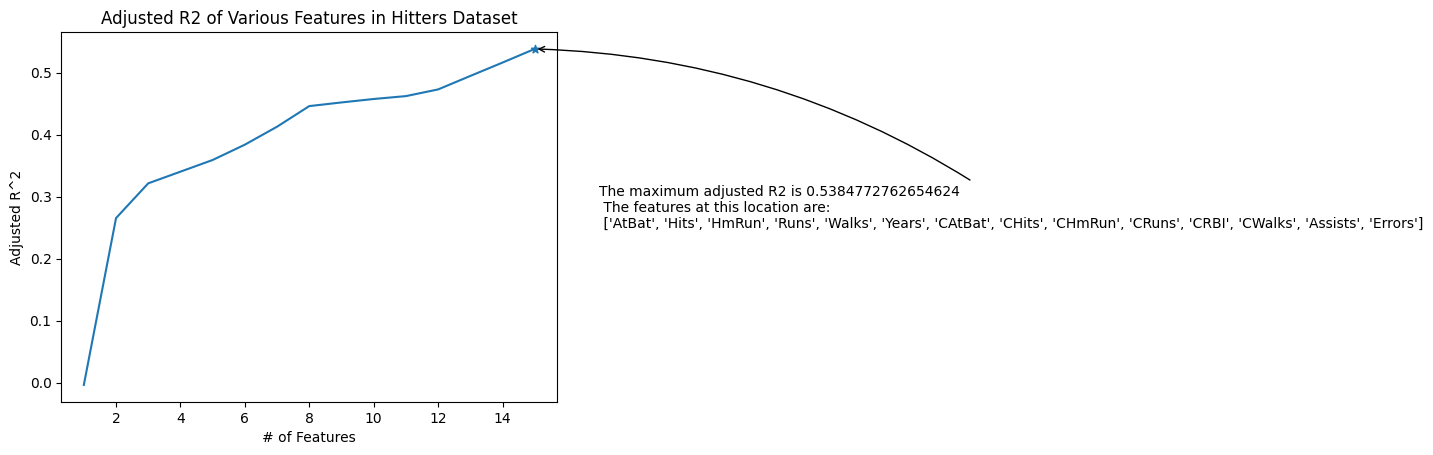

In [106]:
# TODO: Plot the adjusted R^2 values for the number of predictor variables, mark the maximum, and print the predictors associated with that maximum.

adjusted_R2 = []
adjusted_R2 = 1 - (1 - np.array(R2_list_backwards)) * ((len(X_train)-1)/(len(X_train)-np.array(features_list_count)-1))
df_summary.insert(loc=4, column='Adjusted R^2', value=adjusted_R2, allow_duplicates=True)

# Determine the max adjusted R^2
max_adjusted_R2 = adjusted_R2.max()
max_adjusted_R2_index = (np.where(adjusted_R2 == max_adjusted_R2)) # Convert from np array to list
# for item in max_adjusted_R2_index:
max_adjusted_R2_index_int = max_adjusted_R2_index[0][0] #Need to improve to deal with the case when the max is shared by multiple values (long shot)

print(f"max_adjusted_R2: {max_adjusted_R2} at position: {max_adjusted_R2_index_int}")

## PLOT THE VALUES
fig, ax = plt.subplots()

ax.plot(features_list_count, adjusted_R2)
ax.scatter(features_list_count[max_adjusted_R2_index_int],adjusted_R2[max_adjusted_R2_index_int], marker='*')

ax.set_title('Adjusted R2 of Various Features in Hitters Dataset')
ax.set_xlabel('# of Features')
ax.set_ylabel('Adjusted R^2')
# ax.annotate("The maximum R^2 is here", xy=(1890, .065), color='gray', horizontalalignment='left',fontsize=8)

ax.annotate(f"The maximum adjusted R2 is {max_adjusted_R2}\n The features at this location are:\n {features_list_backwards[max_adjusted_R2_index_int]}",
        xy = (features_list_count[max_adjusted_R2_index_int],adjusted_R2[max_adjusted_R2_index_int]),
        xytext = (17,0.25),
        arrowprops=dict(arrowstyle='->',
                        connectionstyle='arc3, rad=0.15'))

plt.show()

Alright! Now, let's check if the number of predictors we determined using the adjusted $R^{2}$ value actually does the best on our test data.

To do this, plot the actual $R^{2}$ value for each set of predictor variables when run on the test data. Again, make the x-axis the number of predictors, mark the maximum, and print the predictors associated with that maximum.

/opt/homebrew/lib/python3.11/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))


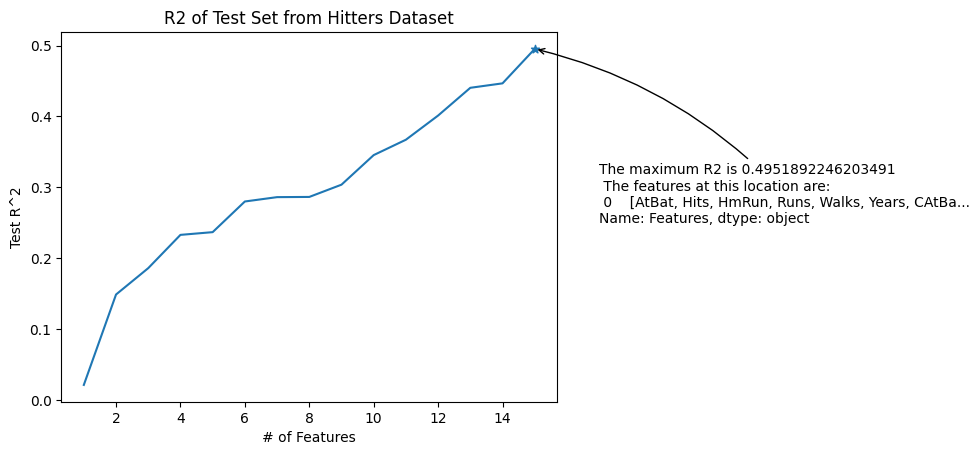

In [105]:
# TODO: Plot the R^2 values for the given number of predictor variables when the model is run on the test data. Mark the maximum, and print the predictors associated with that maximum.
## PLOT THE VALUES
fig, ax = plt.subplots()

ax.plot(df_summary['Features Count'], df_summary['Test R^2'])
ax.scatter(test_r2_max_idx,test_r2_max, marker='*')

ax.set_title('R2 of Test Set from Hitters Dataset')
ax.set_xlabel('# of Features')
ax.set_ylabel('Test R^2')

ax.annotate(f"The maximum R2 is {test_r2_max}\n The features at this location are:\n {test_r2_max_features}",
        xy = (test_r2_max_idx,test_r2_max),
        xytext = (17,0.25),
        arrowprops=dict(arrowstyle='->',
                        connectionstyle='arc3, rad=0.15'))

plt.show()

Now, plot both on the same line charts on the same figure.

test_r2_max: 0.4951892246203491  test_r2_max_idx: 0    15
Name: Features Count, dtype: int64


/opt/homebrew/lib/python3.11/site-packages/matplotlib/text.py:1475: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  x = float(self.convert_xunits(x))


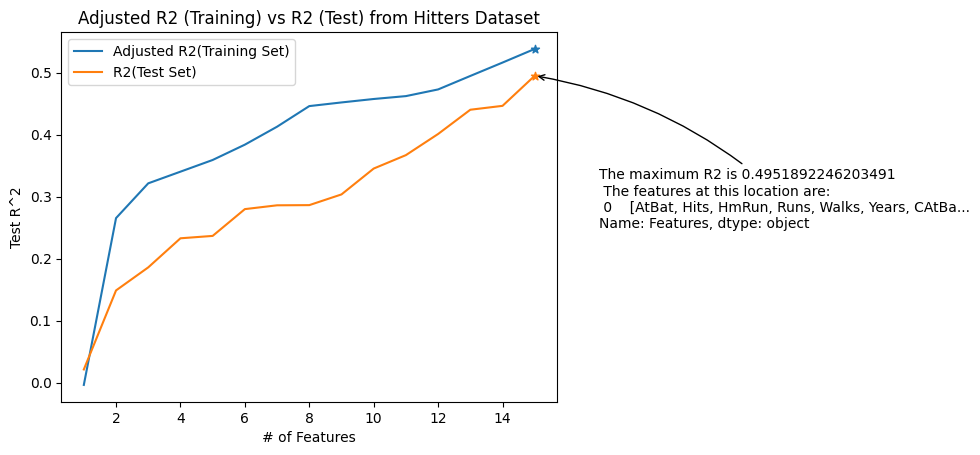

In [108]:
# TODO: Plot both line charts on the same figure.

test_r2_max = df_summary['Test R^2'].max()
test_r2_max_idx = df_summary['Features Count'].loc[df_summary['Test R^2'] == test_r2_max]       # Get the Features Count column where the Test R^2 == max
test_r2_max_features = df_summary['Features'].loc[df_summary['Test R^2'] == test_r2_max]  

print(f"test_r2_max: {test_r2_max}  test_r2_max_idx: {test_r2_max_idx}")

## PLOT THE VALUES
fig, ax = plt.subplots()

ax.plot(features_list_count, adjusted_R2, label='Adjusted R2(Training Set)')
ax.scatter(features_list_count[max_adjusted_R2_index_int],adjusted_R2[max_adjusted_R2_index_int], marker='*')

ax.plot(df_summary['Features Count'], df_summary['Test R^2'], label='R2(Test Set)')
ax.scatter(test_r2_max_idx,test_r2_max, marker='*')

ax.set_title('Adjusted R2 (Training) vs R2 (Test) from Hitters Dataset')
ax.set_xlabel('# of Features')
ax.set_ylabel('Test R^2')

ax.annotate(f"The maximum R2 is {test_r2_max}\n The features at this location are:\n {test_r2_max_features}",
        xy = (test_r2_max_idx,test_r2_max),
        xytext = (17,0.25),
        arrowprops=dict(arrowstyle='->',
                        connectionstyle='arc3, rad=0.15'))

plt.legend()
plt.show()

Do the best subset of predictors found using adjusted $R^{2}$ match those found using a test set?

*Answer:* Yes, the best subset of predictors do match when comparing the training set and test set results suggesting the model does generalize well

## Ridge and Lasso Regression ##

Next, we'll take a look at ridge and lasso regression for this hitters dataset. We'll use ridge regression as an example, and then you should do something similar for lasso.

**Ridge Regression**

We'll first investigate building a predictive salary model using ridge regression.

To do this, first we'll create a set of 90 values for our hyperparameter $\lambda$ as we did in Lectures 9 and 10.

In [32]:
lambdas = 10**np.linspace(7,-2,90)

Now, we'll calculate the values of our coefficients for each value of $\lambda$:

In [33]:
ridge = Ridge()
coefs = [] #Keep track of the coefficients.

for l in lambdas:
    ridge.set_params(alpha = l) #Ridge regression in Python calls the lambda term alpha.
    ridge.fit(X_train, y_train)
    coefs.append(ridge.coef_)

We can plot how these coefficients change as $\lambda$ increases, noting they should approach but not equal $0$ as $\lambda$ gets large.

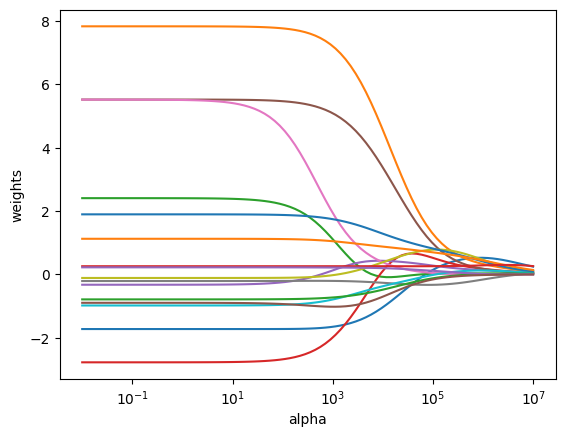

In [34]:
ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');

We can use the RidgeCV function to determine an optimal value for $\lambda$ based on leave-one-out cross-validation (LOOCV):

In [35]:
ridgecv = RidgeCV(alphas = lambdas)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

974460.0632908471

Building a ridge regression model with this optimal $\lambda$, we get:

In [39]:
ridge2 = Ridge(alpha = ridgecv.alpha_)
ridge2.fit(X_train, y_train)
print(pd.Series(ridge2.coef_, index = X.columns))
mean_squared_error(y_train, ridge2.predict(X_train))

AtBat      0.526862
Hits       0.334933
HmRun      0.032936
Runs       0.180023
RBI        0.135657
Walks      0.180378
Years     -0.002140
CAtBat    -0.162237
CHits      0.469750
CHmRun     0.125784
CRuns      0.415408
CRBI       0.446670
CWalks     0.015430
PutOuts    0.287123
Assists    0.016081
Errors    -0.018813
dtype: float64


99653.66259814824

For $3$-fold cross-validation we get:

In [40]:
ridgecv = RidgeCV(alphas = lambdas, cv=3)
ridgecv.fit(X_train, y_train)
ridgecv.alpha_

9253.203955702538

In [41]:
ridge3 = Ridge(alpha = ridgecv.alpha_)
ridge3.fit(X_train, y_train)
print(pd.Series(ridge3.coef_, index = X.columns))
mean_squared_error(y_train, ridge3.predict(X_train))

AtBat     -1.072296
Hits       4.694358
HmRun     -0.070827
Runs       0.046263
RBI        0.432380
Walks      3.463628
Years      0.408537
CAtBat    -0.259429
CHits      0.367618
CHmRun    -0.384516
CRuns      1.306548
CRBI       0.885536
CWalks    -0.492977
PutOuts    0.260714
Assists    0.200746
Errors    -0.722737
dtype: float64


90198.18183080139

For the next part of this homework assignment, you'll investigate the same modeling question using lasso regression and the LassoCV function. Check out the optimal $\lambda$ values you get for lasso regression with LOOCV and 3-fold CV, and note which coefficients are set to $0$ is each case.

Specifically, you should:

1. Plot how the weights change for lasso regression as $\lambda$ gets large.
2. Calculate the optimal value of $\lambda$, and the corresponding model coefficients, using LOOCV.
3. Calculate the optimal value of $\lambda$, and the corresponding model coefficients, using 3-fold CV.

*Note*: Remember, for lasso, you'll probably need to set that max_iter parameter. A value like 100,000 should be good.

/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.697e+03, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.351e+03, tolerance: 4.367e+03
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.545e+03, toleranc

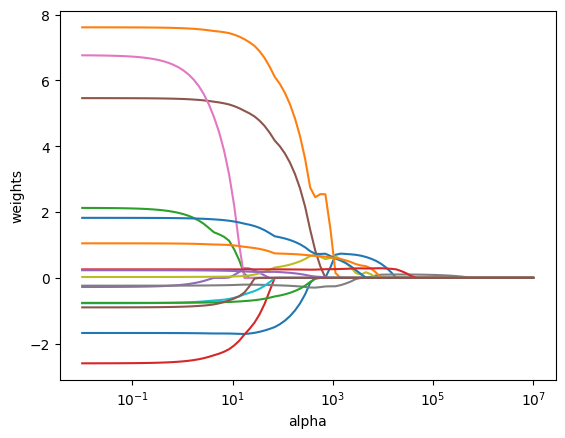

In [42]:
#TODO: Plot how the weights change for lasso regression as lambda gets large here.
lasso = Lasso()
coefs = [] #Keep track of the coefficients.

for l in lambdas:
    lasso.set_params(alpha = l) #Ridge regression in Python calls the lambda term alpha.
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)

ax = plt.gca()
ax.plot(lambdas, coefs)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('weights');    

In [50]:
#TODO: Calculate the optimal value of lambda, and the corresponding model coefficients, using LOOCV.
lassocv = LassoCV(alphas = lambdas) # Rob: No cv parameter defaults to Leave One Out Cross Validation
lassocv.fit(X_train, y_train)
lassocv.alpha_

lasso2 = Lasso(alpha = lassocv.alpha_)
lasso2.fit(X_train, y_train)
print(pd.Series(lasso2.coef_, index = X.columns))
mean_squared_error(y_train, lasso2.predict(X_train))

AtBat     -1.409015
Hits       5.897047
HmRun      0.000000
Runs      -0.000000
RBI        0.000000
Walks      4.000809
Years      0.000000
CAtBat    -0.227107
CHits      0.337394
CHmRun    -0.000000
CRuns      1.234060
CRBI       0.738991
CWalks    -0.535900
PutOuts    0.259369
Assists    0.176235
Errors    -0.000000
dtype: float64


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3340.37578849867, tolerance: 3170.8085667634987
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4318.8106590770185, tolerance: 3170.8085667634987
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 48580.050267064944, tolerance: 3170.8085667634987
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614

89824.52287738575

In [46]:
#TODO: Calculate the optimal value of lambda, and the corresponding model coefficients, using 3-fold CV.
lassocv = LassoCV(alphas = lambdas, cv=3)
lassocv.fit(X_train, y_train)
lassocv.alpha_

lasso3 = Ridge(alpha = ridgecv.alpha_)
lasso3.fit(X_train, y_train)
print(pd.Series(lasso3.coef_, index = X.columns))
mean_squared_error(y_train, lasso3.predict(X_train))

AtBat     -1.072296
Hits       4.694358
HmRun     -0.070827
Runs       0.046263
RBI        0.432380
Walks      3.463628
Years      0.408537
CAtBat    -0.259429
CHits      0.367618
CHmRun    -0.384516
CRuns      1.306548
CRBI       0.885536
CWalks    -0.492977
PutOuts    0.260714
Assists    0.200746
Errors    -0.722737
dtype: float64


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3738.5813123378903, tolerance: 2665.9370231309854
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2965.493688877672, tolerance: 2665.9370231309854
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:614: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3109.9282755441964, tolerance: 2665.9370231309854
  model = cd_fast.enet_coordinate_descent_gram(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:61

90198.18183080139

How do the predictors with non-zero coefficients compare with the ones found earlier in the assignment using backward stepwise selection?

*Answer:* No, the predictors from the lasso regression are not the same as the backward stepwise selection. This isn't entirely surprising since the lasso regression has the benefit of looking at the whole of solution space while the backward stepwise selection is more of a "greedy" algorithm. "Greedy" algorithms, like my children eating candy after trick-or-treating for Halloween, choose what's best for them in the moment and not what's best for them in the long term. The zero-weighted Lasso terms are better indicator of what matters.

This works as long as the number of features and instances is kept relatively small. With thousands of features, running the Lasso regression would be much slower than backward stepwise selection.